

# PLUS
# Specific task 2A-I: Multiple models; multiple languages
Pick a second language. Build a second character-level model for this language and assess its quality. Then assess your first model on the task of generating names for the second language, and vice-versa. How good is the transfer from the first model to the second? How about the other way around? Is this what you expected? Why (not)?

# Data loading

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.9 MB/s eta 0:00:00


In [2]:
!wget https://raw.githubusercontent.com/mrblasco/genderNamesITA/refs/heads/master/gender_firstnames_ITA.csv -O italian_names.csv
!wget https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/refs/heads/master/female_names.csv -O spanish_female_names.csv
!wget https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/refs/heads/master/male_names.csv -O spanish_male_names.csv

--2025-03-02 21:28:19--  https://raw.githubusercontent.com/mrblasco/genderNamesITA/refs/heads/master/gender_firstnames_ITA.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 666528 (651K) [text/plain]
Saving to: ‘italian_names.csv’

italian_names.csv   100%[===================>] 650.91K  --.-KB/s    in 0.05s   

2025-03-02 21:28:20 (12.0 MB/s) - ‘italian_names.csv’ saved [666528/666528]

--2025-03-02 21:28:20--  https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/refs/heads/master/female_names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, await

# Dataset Description

This notebook uses a dataset of Italian names sourced from the GitHub repository [https://raw.githubusercontent.com/mrblasco/genderNamesITA/refs/heads/master/gender_firstnames_ITA.csv](https://raw.githubusercontent.com/mrblasco/genderNamesITA/refs/heads/master/gender_firstnames_ITA.csv).  The original dataset contains names and associated gender information.

**Data Cleaning:**

The names undergo a cleaning process:

1. **Lowercasing:** All names are converted to lowercase.
2. **Special Character Removal:** Numbers and special characters are removed, retaining only letters and periods ('.').  This helps standardize the input and focus the model on character sequences relevant to names.
3. **Whitespace Removal:** Leading and trailing whitespace is removed from each name.

**Vocabulary Creation:**

A vocabulary of characters is constructed from the cleaned names.  A mapping between characters and unique integer representations is created:

* `stoi`: A dictionary mapping each character to a unique integer. The period ('.') is assigned the integer 0, serving as a special token.
* `itos`: The reverse mapping from integers back to characters.

This vocabulary and the cleaned names are used to train a character-level language model, allowing the model to generate new names.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


italian_names = pd.read_csv('italian_names.csv', on_bad_lines='skip', header=0)
spanish_names_female = pd.read_csv('spanish_female_names.csv', header=0, index_col=None)
spanish_names_male = pd.read_csv('spanish_male_names.csv', on_bad_lines='skip', header=0, index_col=None)

spanish_names = pd.concat([spanish_names_female, spanish_names_male])


In [4]:
italian_names.head(3)

,nome,tot,male,female
0,A IPPOLITO,5,5,0
1,A MARIA,5,0,5
2,A. ANGELO,3,3,0


In [5]:
italian_words = italian_names['nome'].astype(str).to_numpy()
spanish_words = spanish_names['name'].astype(str).to_numpy()

In [6]:
class NlpLab2WordsTokenizer:

  def __init__(self, words):
    self.words = [NlpLab2WordsTokenizer.clean_name(word) for word in words]
    self.chars = sorted(list(set(''.join(self.words))))
    self.stoi = {s:i+1 for i,s in enumerate(self.chars)}
    self.stoi['.'] = 0
    self.itos = {i:s for s,i in self.stoi.items()}

  def __len__(self):
    return len(self.words)

  def itos_len(self):
    return len(self.itos)

  def __getitem__(self, idx):
    if type(idx) == str:
      if idx in self.stoi.keys():
        return self.stoi[idx]
      else:
        return 0

    if type(idx) == int:
      if idx in self.itos.keys():
        return self.itos[idx]
      else:
        return '.'

  def __iter__(self):
    for word in self.words:
      yield word

  def show_vocab(self):
    print(self.itos)

  @staticmethod
  def clean_name(name):
    # Remove numbers and special characters, keeping only letters and spaces
    return ''.join(
        [i for i in name.lower() if str.isalpha(i) or i == " "]
      )\
    .strip()

## Dataset Preparation

The cleaned names are then transformed into training, development, and validation datasets using a sliding window approach.

*   **`block_size`:** Determines the context window size (number of previous characters considered when predicting the next character).
*   **`build_dataset`:**  Creates input-output pairs (X, Y) for training.  X represents the context (sequence of characters), and Y represents the target character to predict.




In [7]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

block_size = 5
g_batch_size = 32

torch.manual_seed(0)
random.seed(0)

def test_train_validation_split(tokenizer: NlpLab2WordsTokenizer):

  def build_dataset(tokenizer):
    X, Y = [], []
    words = tokenizer.words
    random.shuffle(tokenizer.words)
    for w in words:
      context = [0] * block_size
      for ch in w + '.':
        ix = tokenizer[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return torch.utils.data.TensorDataset(X, Y) # Return TensorDataset instead of DataLoader

  n1 = int(0.8*len(tokenizer))
  n2 = int(0.9*len(tokenizer))
  dataset = build_dataset(tokenizer)

  # Create DataLoaders from the splits
  train_dataset = torch.utils.data.DataLoader(
      dataset=torch.utils.data.Subset(dataset, range(0, n1)),
      batch_size=g_batch_size,
      shuffle=True
  )
  dev_dataset = torch.utils.data.DataLoader(
      dataset=torch.utils.data.Subset(dataset, range(n1, n2)),
      batch_size=g_batch_size,
      shuffle=False
  )
  validation_dataset = torch.utils.data.DataLoader(
      dataset=torch.utils.data.Subset(dataset, range(n2, len(tokenizer))),
      batch_size=g_batch_size,
      shuffle=False
  )
  print("Train dataset size:", len(train_dataset.dataset))
  print("Dev dataset size:", len(dev_dataset.dataset))
  print("Validation dataset size:", len(validation_dataset.dataset))

  return train_dataset, dev_dataset, validation_dataset


## Model Architecture

A character-level language model is defined using a feedforward neural network:

*   **Embedding Layer:** Maps each character to a vector representation.
*   **Linear Layers:**  Process the concatenated character embeddings to predict the probability distribution over the vocabulary of characters.
*   **ReLU Activation:**  Introduces non-linearity.



In [8]:

class FeedForwardNet(torch.nn.Module):

    def __init__(self, chars_number=39, embedding_dim=10, hidden_dim=300, context_size=block_size):
        super().__init__()
        self.context_size = context_size
        self.embedding = torch.nn.Embedding(chars_number, embedding_dim)
        self.model = torch.nn.Sequential(
            torch.nn.Linear(context_size * embedding_dim, hidden_dim * 3),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim * 3, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, chars_number),
            # The model uses CrossEntr
        )

    def forward(self, x):
        # x shape: (batch_size, context_size)
        if not torch.all(x >= 0) and torch.all(x < self.embedding.num_embeddings):
            raise ValueError("Inappropriate input data. One of the vector contains the value the embedding can not process")

        emb = self.embedding(x)  # shape: (batch_size, context_size, embedding_dim)
        emb = emb.view(emb.shape[0], -1)  # shape: (batch_size, context_size * embedding_dim)
        return self.model(emb)

    def generate_masked_names(self, mask, tokenizer, num_names=10):
      """
        The masked names generator
      """
      generated_names = []
      for _ in range(num_names):
          context = [0] * self.context_size
          name = ""
          for char in mask:
            if char == "#":
              input_tensor = torch.tensor([context], dtype=torch.long).to(device)
              output = self.forward(input_tensor)
              probabilities = F.softmax(output, dim=1)
              next_char_index = torch.multinomial(probabilities, num_samples=1).item()
              if next_char_index == 0:  # End of name
                  break
              next_char = tokenizer[next_char_index]
              name += next_char
              context = context[1:] + [next_char_index]
            else:
              if char in tokenizer.stoi:
                ix = tokenizer[char]
                name += char
                context = context[1:] + [ix]
              else:
                # Handle characters not in the vocabulary
                print(f"Warning: Character '{char}' not in vocabulary. Skipping.")
                continue
          generated_names.append(name)
      return generated_names

    def generate_names_starting_with(self, prefix, tokenizer, num_names=10, max_len=15):
      """
      This is a particularly non-efficient N +
      """
      generated_names = []
      for _ in range(num_names):
          context = [0] * self.context_size
          name = ""
          # Initialize context with prefix
          for char in prefix:
              if char in tokenizer.stoi:
                ix = tokenizer[char]
                name += char
                context = context[1:] + [ix]
              else:
                # Handle characters not in the vocabulary
                print(f"Warning: Character '{char}' not in vocabulary. Skipping.")
                continue

          for _ in range(max_len - len(prefix)):
              input_tensor = torch.tensor([context], dtype=torch.long).to(device)
              output = self.forward(input_tensor)
              probabilities = F.softmax(output, dim=1)
              next_char_index = torch.multinomial(probabilities, num_samples=1).item()

              if next_char_index == 0:  # End of name
                  break
              next_char = tokenizer[next_char_index]
              name += next_char
              context = context[1:] + [next_char_index]
          generated_names.append(name)
      return generated_names



# The model selection and training function

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_dataset, dev_dataset, epochs=3, lr=0.1):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    dev_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, y in tqdm(train_dataset, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_dataset))

        model.eval()
        dev_loss = 0
        with torch.no_grad():
            for X, y in dev_dataset:
                X, y = X.to(device), y.to(device)
                output = model(X)
                loss = criterion(output, y)
                dev_loss += loss.item()
        dev_losses.append(dev_loss / len(dev_dataset))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Dev Loss: {dev_losses[-1]}")

    return train_losses, dev_losses



#General task Exercise 2A:

Train a character-level language model to generate names (persons, companies, animals, etc) in your language of choice. Assess your model's quality.

In this excercise it's been decided to choose an Italian names dataset.

The pipeline as follows:
1. Tokenization and data preparation
2. Best hyperparams selection (tuning)
3. Final epoch training and Metrics collection

In [10]:
italian_names_tokenizer = NlpLab2WordsTokenizer(italian_words)
italian_train_dataset, italian_dev_dataset, italian_validation_dataset = test_train_validation_split(italian_names_tokenizer)

torch.Size([435769, 5]) torch.Size([435769])
Train dataset size: 26275
Dev dataset size: 3284
Validation dataset size: 3285


In [11]:
import optuna


def fit_objective(trial):
    # Define the hyperparameters to be tuned
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    embedding_dim = trial.suggest_int("embedding_dim", 10, 100)
    hidden_dim = trial.suggest_int("hidden_dim", 100, 500)

    # Create a new model instance with the suggested hyperparameters
    model = FeedForwardNet(italian_names_tokenizer.itos_len(), embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

    # Train the model
    train_losses, dev_losses = train_model(model, italian_train_dataset, italian_dev_dataset, epochs=5, lr=lr) # Here I reduced epochs for faster tuning

    # Return the validation loss as the objective value to minimize
    return dev_losses[-1]

study = optuna.create_study(direction="minimize")
study.optimize(fit_objective, n_trials=20)

# Print the best hyperparameters and the corresponding validation loss
print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

# Train the final model with the best hyperparameters
italian_model = FeedForwardNet(italian_names_tokenizer.itos_len(), embedding_dim=study.best_params['embedding_dim'], hidden_dim=study.best_params['hidden_dim']).to(device)

it_train_losses, it_dev_losses = train_model(italian_model, italian_train_dataset, italian_dev_dataset, epochs=20, lr=study.best_params['lr'])


[I 2025-03-02 21:28:38,534] A new study created in memory with name: no-name-2e97fa2b-1a76-480a-ac7a-3ed1f18be5b7
Epoch 1/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 158.77it/s]


Epoch 1/5, Train Loss: 2.090957506149645, Dev Loss: 2.3952243420684223


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 153.96it/s]


Epoch 2/5, Train Loss: 1.657807004712794, Dev Loss: 2.221151724602412


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 171.75it/s]


Epoch 3/5, Train Loss: 1.5004397014341795, Dev Loss: 1.6136408326695266


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 211.84it/s]


Epoch 4/5, Train Loss: 1.4048925566412236, Dev Loss: 1.6857746121952835


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 195.54it/s]
[I 2025-03-02 21:29:15,153] Trial 0 finished with value: 1.5618715546663524 and parameters: {'lr': 0.07480832009996836, 'embedding_dim': 49, 'hidden_dim': 267}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 1.339473882187022, Dev Loss: 1.5618715546663524


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 343.84it/s]


Epoch 1/5, Train Loss: 3.490866224551143, Dev Loss: 3.487065007385698


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:01<00:00, 444.29it/s]


Epoch 2/5, Train Loss: 3.4855179940407, Dev Loss: 3.48192275843574


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:01<00:00, 448.57it/s]


Epoch 3/5, Train Loss: 3.480255999704347, Dev Loss: 3.4767833635645005


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:01<00:00, 440.09it/s]


Epoch 4/5, Train Loss: 3.4751239408831816, Dev Loss: 3.4716452603201264


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:01<00:00, 449.93it/s]
[I 2025-03-02 21:29:25,430] Trial 1 finished with value: 3.466467739308922 and parameters: {'lr': 2.5906248678100585e-05, 'embedding_dim': 61, 'hidden_dim': 126}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 3.469949861802614, Dev Loss: 3.466467739308922


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:06<00:00, 126.72it/s]


Epoch 1/5, Train Loss: 2.057420932898556, Dev Loss: 2.052932218440528


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 149.42it/s]


Epoch 2/5, Train Loss: 1.6241488783028875, Dev Loss: 1.6525598463502902


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:06<00:00, 128.43it/s]


Epoch 3/5, Train Loss: 1.471615401932793, Dev Loss: 1.6309594697165257


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 155.20it/s]


Epoch 4/5, Train Loss: 1.3766776774341463, Dev Loss: 1.5984470763252776


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:06<00:00, 132.26it/s]
[I 2025-03-02 21:29:56,530] Trial 2 finished with value: 1.9041254254220759 and parameters: {'lr': 0.08657961272079609, 'embedding_dim': 35, 'hidden_dim': 476}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 1.3124102288064006, Dev Loss: 1.9041254254220759


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 359.84it/s]


Epoch 1/5, Train Loss: 3.4859442635464264, Dev Loss: 3.4818479019461326


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 362.11it/s]


Epoch 2/5, Train Loss: 3.4767876805470226, Dev Loss: 3.4728456145351374


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 247.60it/s]


Epoch 3/5, Train Loss: 3.467767808849214, Dev Loss: 3.4638819185275476


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 250.07it/s]


Epoch 4/5, Train Loss: 3.458721259504629, Dev Loss: 3.4548939616934766


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 350.00it/s]
[I 2025-03-02 21:30:10,653] Trial 3 finished with value: 3.4459185229921805 and parameters: {'lr': 2.1044834824474747e-05, 'embedding_dim': 22, 'hidden_dim': 246}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 3.449512313462232, Dev Loss: 3.4459185229921805


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:01<00:00, 496.10it/s]


Epoch 1/5, Train Loss: 3.4985351063619277, Dev Loss: 3.4951105326124767


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:01<00:00, 494.88it/s]


Epoch 2/5, Train Loss: 3.493040115873889, Dev Loss: 3.4898157027161236


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:01<00:00, 481.03it/s]


Epoch 3/5, Train Loss: 3.4878404822082705, Dev Loss: 3.4846016967180864


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:01<00:00, 471.25it/s]


Epoch 4/5, Train Loss: 3.482595804253924, Dev Loss: 3.4793983246516254


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 328.18it/s]
[I 2025-03-02 21:30:20,457] Trial 4 finished with value: 3.4742421849260055 and parameters: {'lr': 2.8416137653866804e-05, 'embedding_dim': 46, 'hidden_dim': 118}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 3.477217787663722, Dev Loss: 3.4742421849260055


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 372.69it/s]


Epoch 1/5, Train Loss: 3.0398155012850054, Dev Loss: 2.760227404751824


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 378.07it/s]


Epoch 2/5, Train Loss: 2.590936688466084, Dev Loss: 2.488589865490071


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 356.75it/s]


Epoch 3/5, Train Loss: 2.376234586656529, Dev Loss: 2.3425710363295473


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 373.12it/s]


Epoch 4/5, Train Loss: 2.2539650884858013, Dev Loss: 2.252235818835138


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 270.13it/s]
[I 2025-03-02 21:30:33,028] Trial 5 finished with value: 2.1731193505444573 and parameters: {'lr': 0.0032310761975820634, 'embedding_dim': 71, 'hidden_dim': 158}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 2.1665717441670216, Dev Loss: 2.1731193505444573


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 207.36it/s]


Epoch 1/5, Train Loss: 2.9786539527331537, Dev Loss: 2.7370794398113363


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 225.92it/s]


Epoch 2/5, Train Loss: 2.5859737561566987, Dev Loss: 2.509453967936988


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 177.86it/s]


Epoch 3/5, Train Loss: 2.388060878228097, Dev Loss: 2.3642126807888735


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 224.90it/s]


Epoch 4/5, Train Loss: 2.2667343223472, Dev Loss: 2.2729301660963634


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 227.16it/s]
[I 2025-03-02 21:30:53,513] Trial 6 finished with value: 2.2074962622911025 and parameters: {'lr': 0.002356936039178329, 'embedding_dim': 64, 'hidden_dim': 323}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 2.184546777656769, Dev Loss: 2.2074962622911025


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:07<00:00, 111.75it/s]


Epoch 1/5, Train Loss: 2.123199532791936, Dev Loss: 2.078179351334433


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:06<00:00, 133.65it/s]


Epoch 2/5, Train Loss: 1.6723182835863164, Dev Loss: 1.8278076741301899


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:07<00:00, 112.27it/s]


Epoch 3/5, Train Loss: 1.5142432287371652, Dev Loss: 1.716110136902448


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:06<00:00, 132.53it/s]


Epoch 4/5, Train Loss: 1.4172935023940103, Dev Loss: 1.5978658731701305


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:07<00:00, 115.50it/s]
[I 2025-03-02 21:31:29,163] Trial 7 finished with value: 1.6136170862947854 and parameters: {'lr': 0.051462493139513066, 'embedding_dim': 61, 'hidden_dim': 492}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 1.3468856575860304, Dev Loss: 1.6136170862947854


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 139.85it/s]


Epoch 1/5, Train Loss: 3.524201784980848, Dev Loss: 3.5228978476478057


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 137.13it/s]


Epoch 2/5, Train Loss: 3.5165107273417378, Dev Loss: 3.515424901999316


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 145.73it/s]


Epoch 3/5, Train Loss: 3.5089624757604296, Dev Loss: 3.508042687351264


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:06<00:00, 130.68it/s]


Epoch 4/5, Train Loss: 3.5014150992507194, Dev Loss: 3.5007389355631706


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 149.93it/s]
[I 2025-03-02 21:32:00,083] Trial 8 finished with value: 3.4935133480331273 and parameters: {'lr': 1.1096939660085378e-05, 'embedding_dim': 65, 'hidden_dim': 441}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 3.494076927792997, Dev Loss: 3.4935133480331273


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 293.78it/s]


Epoch 1/5, Train Loss: 2.6806933067720884, Dev Loss: 2.425311808447236


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:01<00:00, 414.12it/s]


Epoch 2/5, Train Loss: 2.283319855113389, Dev Loss: 2.243840464110513


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:01<00:00, 415.28it/s]


Epoch 3/5, Train Loss: 2.12549601810692, Dev Loss: 2.148889707130136


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:01<00:00, 415.60it/s]


Epoch 4/5, Train Loss: 2.0142997464124304, Dev Loss: 2.024494487105064


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:01<00:00, 420.51it/s]
[I 2025-03-02 21:32:11,299] Trial 9 finished with value: 1.94335516563897 and parameters: {'lr': 0.010291437760721885, 'embedding_dim': 22, 'hidden_dim': 199}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 1.9201731297511544, Dev Loss: 1.94335516563897


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 141.22it/s]


Epoch 1/5, Train Loss: 3.422422896336465, Dev Loss: 3.351875837566783


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 172.55it/s]


Epoch 2/5, Train Loss: 3.2735060073453432, Dev Loss: 3.197329792004187


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 141.67it/s]


Epoch 3/5, Train Loss: 3.1155748985109537, Dev Loss: 3.049414849975734


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 174.47it/s]


Epoch 4/5, Train Loss: 2.984640291137417, Dev Loss: 2.9452528143392027


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 171.52it/s]
[I 2025-03-02 21:32:38,387] Trial 10 finished with value: 2.878823058119098 and parameters: {'lr': 0.00028259228647246247, 'embedding_dim': 97, 'hidden_dim': 350}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 2.8980984348450263, Dev Loss: 2.878823058119098


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 163.38it/s]


Epoch 1/5, Train Loss: 2.019302511592271, Dev Loss: 1.9311823231502645


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 196.33it/s]


Epoch 2/5, Train Loss: 1.6083072804802816, Dev Loss: 1.6335024816318624


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 168.75it/s]


Epoch 3/5, Train Loss: 1.460049451630191, Dev Loss: 1.6830783387989674


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 195.71it/s]


Epoch 4/5, Train Loss: 1.3673813013119709, Dev Loss: 1.6916998497490745


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 200.80it/s]
[I 2025-03-02 21:33:01,880] Trial 11 finished with value: 1.6942641179538467 and parameters: {'lr': 0.09387991720516291, 'embedding_dim': 44, 'hidden_dim': 394}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 1.3029266933020014, Dev Loss: 1.6942641179538467


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 186.19it/s]


Epoch 1/5, Train Loss: 2.391136085900077, Dev Loss: 2.1988178584182148


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 241.73it/s]


Epoch 2/5, Train Loss: 1.934088124555973, Dev Loss: 1.9615551742535193


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 241.93it/s]


Epoch 3/5, Train Loss: 1.7542305419044772, Dev Loss: 1.7885718085233449


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 200.60it/s]


Epoch 4/5, Train Loss: 1.633719106950319, Dev Loss: 1.7187459596152443


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 217.39it/s]
[I 2025-03-02 21:33:21,892] Trial 12 finished with value: 1.7061090006411654 and parameters: {'lr': 0.017905552772787645, 'embedding_dim': 84, 'hidden_dim': 266}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 1.545318824313853, Dev Loss: 1.7061090006411654


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 176.43it/s]


Epoch 1/5, Train Loss: 2.3251396766399237, Dev Loss: 2.049930941711352


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 144.21it/s]


Epoch 2/5, Train Loss: 1.8631441029028881, Dev Loss: 1.8405563079037712


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 177.22it/s]


Epoch 3/5, Train Loss: 1.6797396056263407, Dev Loss: 1.7658693946680977


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 168.58it/s]


Epoch 4/5, Train Loss: 1.563425810740232, Dev Loss: 1.672931180416959


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 152.84it/s]
[I 2025-03-02 21:33:48,349] Trial 13 finished with value: 1.6617203320114358 and parameters: {'lr': 0.0201850200750051, 'embedding_dim': 79, 'hidden_dim': 384}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 1.4823001452025997, Dev Loss: 1.6617203320114358


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 148.53it/s]


Epoch 1/5, Train Loss: 3.387214021961184, Dev Loss: 3.281549858815462


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:06<00:00, 123.76it/s]


Epoch 2/5, Train Loss: 3.172389104998605, Dev Loss: 3.07825841024084


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 144.47it/s]


Epoch 3/5, Train Loss: 2.9960728938852204, Dev Loss: 2.9442426649112146


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:06<00:00, 124.47it/s]


Epoch 4/5, Train Loss: 2.8861692647864348, Dev Loss: 2.8618146007500807


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:05<00:00, 146.97it/s]
[I 2025-03-02 21:34:19,686] Trial 14 finished with value: 2.803888242221573 and parameters: {'lr': 0.00032289716958646, 'embedding_dim': 48, 'hidden_dim': 498}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 2.8148155165994835, Dev Loss: 2.803888242221573


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 220.11it/s]


Epoch 1/5, Train Loss: 2.260677302695829, Dev Loss: 2.3219284629358827


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 294.82it/s]


Epoch 2/5, Train Loss: 1.787566340136412, Dev Loss: 1.887722788505184


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 296.41it/s]


Epoch 3/5, Train Loss: 1.608176693936624, Dev Loss: 2.262692730403641


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 297.01it/s]


Epoch 4/5, Train Loss: 1.5021440454208068, Dev Loss: 1.891330960884835


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 215.19it/s]
[I 2025-03-02 21:34:36,286] Trial 15 finished with value: 1.707576951934296 and parameters: {'lr': 0.04238111160044691, 'embedding_dim': 36, 'hidden_dim': 281}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 1.427386725906038, Dev Loss: 1.707576951934296


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 324.34it/s]


Epoch 1/5, Train Loss: 2.9231232578737023, Dev Loss: 2.6373502467442487


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 326.15it/s]


Epoch 2/5, Train Loss: 2.4475747090186517, Dev Loss: 2.3478662470012037


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 329.11it/s]


Epoch 3/5, Train Loss: 2.2306788195368727, Dev Loss: 2.20667410822748


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 258.87it/s]


Epoch 4/5, Train Loss: 2.1135109156877747, Dev Loss: 2.1108611139278968


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 298.77it/s]
[I 2025-03-02 21:34:50,494] Trial 16 finished with value: 2.0467126357902603 and parameters: {'lr': 0.004619005712730688, 'embedding_dim': 55, 'hidden_dim': 221}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 2.026853194056926, Dev Loss: 2.0467126357902603


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 272.42it/s]


Epoch 1/5, Train Loss: 3.2689862410807553, Dev Loss: 3.085174055932795


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 269.28it/s]


Epoch 2/5, Train Loss: 2.9604838631158907, Dev Loss: 2.8922278996810173


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 207.38it/s]


Epoch 3/5, Train Loss: 2.8253136429473433, Dev Loss: 2.799463823003676


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 271.66it/s]


Epoch 4/5, Train Loss: 2.746186311517609, Dev Loss: 2.7346618569012984


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 272.25it/s]
[I 2025-03-02 21:35:07,403] Trial 17 finished with value: 2.6805800303672123 and parameters: {'lr': 0.0007227011362868613, 'embedding_dim': 34, 'hidden_dim': 316}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 2.6853930349767645, Dev Loss: 2.6805800303672123


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 231.97it/s]


Epoch 1/5, Train Loss: 2.437119222615467, Dev Loss: 2.2826657873912923


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 176.78it/s]


Epoch 2/5, Train Loss: 2.023889462733211, Dev Loss: 2.1389893304954453


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 229.36it/s]


Epoch 3/5, Train Loss: 1.830460933075624, Dev Loss: 1.8402288990113342


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 220.24it/s]


Epoch 4/5, Train Loss: 1.705216166311807, Dev Loss: 1.8407239994956452


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:04<00:00, 173.90it/s]
[I 2025-03-02 21:35:28,601] Trial 18 finished with value: 1.9671449568665142 and parameters: {'lr': 0.025733106016948205, 'embedding_dim': 12, 'hidden_dim': 411}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 1.6198468268497728, Dev Loss: 1.9671449568665142


Epoch 1/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 337.74it/s]


Epoch 1/5, Train Loss: 2.706809607590492, Dev Loss: 2.363401338892076


Epoch 2/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 334.35it/s]


Epoch 2/5, Train Loss: 2.1884985231135015, Dev Loss: 2.1287910567903983


Epoch 3/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 337.18it/s]


Epoch 3/5, Train Loss: 2.009504006581875, Dev Loss: 2.0131153608988788


Epoch 4/5 - Training: 100%|██████████| 822/822 [00:03<00:00, 244.21it/s]


Epoch 4/5, Train Loss: 1.886247717841118, Dev Loss: 1.9037443017496647


Epoch 5/5 - Training: 100%|██████████| 822/822 [00:02<00:00, 333.86it/s]
[I 2025-03-02 21:35:42,404] Trial 19 finished with value: 1.853075894337256 and parameters: {'lr': 0.009603602084530379, 'embedding_dim': 74, 'hidden_dim': 181}. Best is trial 0 with value: 1.5618715546663524.


Epoch 5/5, Train Loss: 1.7920261502555976, Dev Loss: 1.853075894337256
Best hyperparameters: {'lr': 0.07480832009996836, 'embedding_dim': 49, 'hidden_dim': 267}
Best validation loss: 1.5618715546663524


Epoch 1/20 - Training: 100%|██████████| 822/822 [00:02<00:00, 274.25it/s]


Epoch 1/20, Train Loss: 2.093323777336854, Dev Loss: 2.075114725862892


Epoch 2/20 - Training: 100%|██████████| 822/822 [00:03<00:00, 272.43it/s]


Epoch 2/20, Train Loss: 1.6573671409973554, Dev Loss: 2.0149895427296465


Epoch 3/20 - Training: 100%|██████████| 822/822 [00:03<00:00, 209.65it/s]


Epoch 3/20, Train Loss: 1.4988183060121651, Dev Loss: 1.889593063627632


Epoch 4/20 - Training: 100%|██████████| 822/822 [00:02<00:00, 285.53it/s]


Epoch 4/20, Train Loss: 1.407047893951699, Dev Loss: 1.5707021529234728


Epoch 5/20 - Training: 100%|██████████| 822/822 [00:03<00:00, 249.25it/s]


Epoch 5/20, Train Loss: 1.3353457526278902, Dev Loss: 1.7619244508372927


Epoch 6/20 - Training: 100%|██████████| 822/822 [00:04<00:00, 189.75it/s]


Epoch 6/20, Train Loss: 1.283420046605623, Dev Loss: 1.54302341151006


Epoch 7/20 - Training: 100%|██████████| 822/822 [00:04<00:00, 187.60it/s]


Epoch 7/20, Train Loss: 1.2373890657784585, Dev Loss: 1.617103861373605


Epoch 8/20 - Training: 100%|██████████| 822/822 [00:02<00:00, 276.87it/s]


Epoch 8/20, Train Loss: 1.205488546341295, Dev Loss: 1.8704127750350434


Epoch 9/20 - Training: 100%|██████████| 822/822 [00:02<00:00, 274.64it/s]


Epoch 9/20, Train Loss: 1.171537299878406, Dev Loss: 1.6938929951306685


Epoch 10/20 - Training: 100%|██████████| 822/822 [00:03<00:00, 236.80it/s]


Epoch 10/20, Train Loss: 1.139699783130864, Dev Loss: 1.5346533638759725


Epoch 11/20 - Training: 100%|██████████| 822/822 [00:03<00:00, 239.63it/s]


Epoch 11/20, Train Loss: 1.1088913337230102, Dev Loss: 1.537800443982615


Epoch 12/20 - Training: 100%|██████████| 822/822 [00:02<00:00, 278.81it/s]


Epoch 12/20, Train Loss: 1.0859200818477757, Dev Loss: 1.5940813896725479


Epoch 13/20 - Training: 100%|██████████| 822/822 [00:02<00:00, 280.59it/s]


Epoch 13/20, Train Loss: 1.0644246001893296, Dev Loss: 1.557969584048373


Epoch 14/20 - Training: 100%|██████████| 822/822 [00:03<00:00, 217.31it/s]


Epoch 14/20, Train Loss: 1.0458994872161071, Dev Loss: 1.600873693679143


Epoch 15/20 - Training: 100%|██████████| 822/822 [00:03<00:00, 260.33it/s]


Epoch 15/20, Train Loss: 1.0310527888600263, Dev Loss: 1.5963089089949154


Epoch 16/20 - Training: 100%|██████████| 822/822 [00:02<00:00, 282.45it/s]


Epoch 16/20, Train Loss: 1.0169305846711434, Dev Loss: 1.5995601427207873


Epoch 17/20 - Training: 100%|██████████| 822/822 [00:02<00:00, 275.55it/s]


Epoch 17/20, Train Loss: 1.0026315042971115, Dev Loss: 1.5885940986929588


Epoch 18/20 - Training: 100%|██████████| 822/822 [00:03<00:00, 208.67it/s]


Epoch 18/20, Train Loss: 0.9933621335203631, Dev Loss: 1.7333105929846901


Epoch 19/20 - Training: 100%|██████████| 822/822 [00:02<00:00, 278.40it/s]


Epoch 19/20, Train Loss: 0.9869080610808955, Dev Loss: 1.6103209922614607


Epoch 20/20 - Training: 100%|██████████| 822/822 [00:02<00:00, 276.15it/s]


Epoch 20/20, Train Loss: 0.9727726521065635, Dev Loss: 1.6000925279358058


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualise_losses(train_losses, dev_losses, language):
  epochs = range(1, len(train_losses) + 1)
  plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
  sns.set_style("whitegrid")  # Set a visually appealing style with a grid

  sns.lineplot(x=epochs, y=train_losses, label="Training Loss")
  sns.lineplot(x=epochs, y=dev_losses, label="Dev Loss")


  plt.xlabel("Epochs", fontsize=14)
  plt.ylabel("Loss (CrossEntropy)", fontsize=14)
  plt.title(f"Training and Dev Losses for {language} language", fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, linestyle="--", alpha=0.7) # Customize grid appearance
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  sns.despine(left=True, bottom=True) # Improve aesthetics by removing top/right borders

  plt.show()


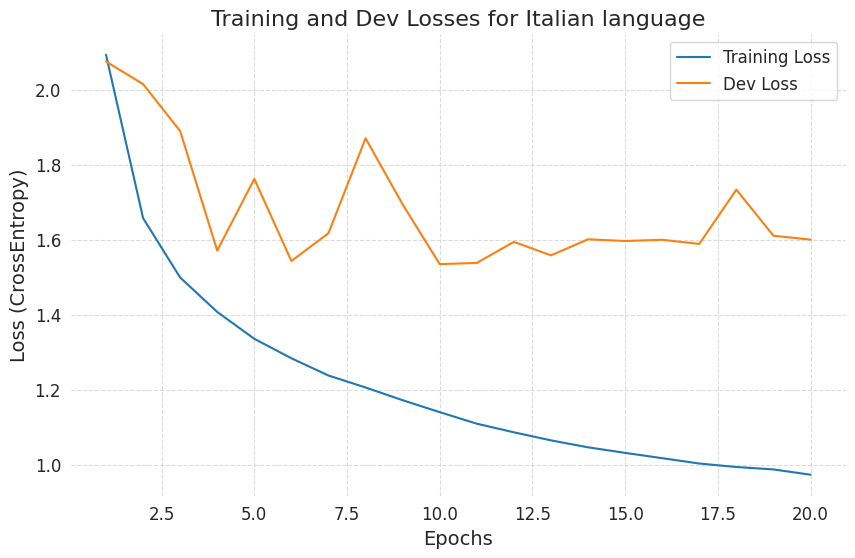

In [13]:
visualise_losses(it_train_losses, it_dev_losses, "Italian")

## Training and Evaluation

The model is trained using the following:

*   **CrossEntropyLoss:**  Calculates the loss between predicted and actual characters.
*   **SGD Optimizer:**  Updates model parameters based on the calculated loss.
*   **Training Loop:** Iterates over the training data, calculating loss, backpropagating gradients, and updating the model.

The model's performance is evaluated on the development set to monitor its generalization. Training and validation losses are plotted to visualize training progress.



In [14]:
def calculate_perplexity(model, dataset):
    """Calculates the perplexity of the model on the given dataset."""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in dataset:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = F.cross_entropy(output, y) # Use cross_entropy directly for perplexity
            total_loss += loss.item() * len(y)  # Scale loss by batch size
    avg_loss = total_loss / len(dataset.dataset)
    perplexity = torch.exp(torch.tensor(avg_loss)).item()
    return perplexity

def calculate_character_accuracy(model, dataset):
    """Calculates character-level accuracy."""
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for X, y in dataset:
            X, y = X.to(device), y.to(device)
            output = model(X)
            predictions = torch.argmax(output, dim=1)
            correct_predictions += (predictions == y).sum().item()
            total_predictions += len(y)
    accuracy = correct_predictions / total_predictions
    return accuracy


# Example usage:
perplexity = calculate_perplexity(italian_model, italian_validation_dataset)
accuracy = calculate_character_accuracy(italian_model, italian_validation_dataset)

print(f"Perplexity on validation set: {perplexity}")
print(f"Character Accuracy on validation set: {accuracy}")

expected_names = italian_names_tokenizer.words[:15]
generated_names = []

for exp_name in expected_names:
  generated_names.append(italian_model.generate_names_starting_with(exp_name[:4], tokenizer=italian_names_tokenizer, num_names=1, max_len=len(exp_name))[-1])

# Compare the generated names with the expected names (example comparison)
print("\nComparison:")
for i in range(10):
    print(f"Generated: {generated_names[i]}, Fully taken name (example): {expected_names[i]}")



Perplexity on validation set: 4.72767448425293
Character Accuracy on validation set: 0.5397260273972603

Comparison:
Generated: ugo rosa, Fully taken name (example): ugo luigi
Generated: laure harsco, Fully taken name (example): laura melania
Generated: viatantonio, Fully taken name (example): viatantonio
Generated: antonella, Fully taken name (example): antonietta rosetta
Generated: emidio, Fully taken name (example): emidio
Generated: amata, Fully taken name (example): amata
Generated: massimiliana, Fully taken name (example): massimo gaetano
Generated: maria, Fully taken name (example): maria
Generated: sergio ivo, Fully taken name (example): sergio aristide
Generated: mario, Fully taken name (example): mario virginio


#Specific task 2A-I: Multiple models; multiple languages

Pick a second language. Build a second character-level model for this language and assess its quality. Then assess your first model on the task of generating names for the second language, and vice-versa. How good is the transfer from the first model to the second? How about the other way around? Is this what you expected? Why (not)?

Second language: Spanish

In [15]:
import optuna

spanish_names_tokenizer = NlpLab2WordsTokenizer(spanish_words)
spanish_train_dataset, spanish_dev_dataset, spanish_validation_dataset = test_train_validation_split(spanish_names_tokenizer)

def fit_objective(trial):
    # Define the hyperparameters to be tuned
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    embedding_dim = trial.suggest_int("embedding_dim", 10, 200)
    hidden_dim = trial.suggest_int("hidden_dim", 100, 500)

    # Create a new model instance with the suggested hyperparameters
    model = FeedForwardNet(spanish_names_tokenizer.itos_len(), embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

    # Train the model
    train_losses, dev_losses = train_model(model, spanish_train_dataset, spanish_dev_dataset, epochs=5, lr=lr) # Here I reduced epochs for faster tuning

    # Return the validation loss as the objective value to minimize
    return dev_losses[-1]

study = optuna.create_study(direction="minimize")
study.optimize(fit_objective, n_trials=20) # Adjust n_trials as needed

# Print the best hyperparameters and the corresponding validation loss
print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

# Train the final model with the best hyperparameters
spanish_model = FeedForwardNet(spanish_names_tokenizer.itos_len(), embedding_dim=study.best_params['embedding_dim'], hidden_dim=study.best_params['hidden_dim']).to(device)

sp_train_losses, sp_dev_losses = train_model(spanish_model, spanish_train_dataset, spanish_dev_dataset, epochs=10, lr=study.best_params['lr'])


[I 2025-03-02 21:36:55,023] A new study created in memory with name: no-name-be267edd-7de0-40e0-95ef-e69104048182


torch.Size([585127, 5]) torch.Size([585127])
Train dataset size: 39472
Dev dataset size: 4934
Validation dataset size: 4934


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:10<00:00, 115.19it/s]


Epoch 1/5, Train Loss: 3.379393334520114, Dev Loss: 3.3453902413768155


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:10<00:00, 116.43it/s]


Epoch 2/5, Train Loss: 3.309264224004514, Dev Loss: 3.277007581341651


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:10<00:00, 117.06it/s]


Epoch 3/5, Train Loss: 3.2398651676007955, Dev Loss: 3.207345868695167


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:10<00:00, 116.43it/s]


Epoch 4/5, Train Loss: 3.169348554441183, Dev Loss: 3.1377620527821204


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:10<00:00, 117.92it/s]
[I 2025-03-02 21:37:49,969] Trial 0 finished with value: 3.073685504544166 and parameters: {'lr': 9.458779288786431e-05, 'embedding_dim': 170, 'hidden_dim': 347}. Best is trial 0 with value: 3.073685504544166.


Epoch 5/5, Train Loss: 3.1016361937530617, Dev Loss: 3.073685504544166


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:16<00:00, 76.77it/s]


Epoch 1/5, Train Loss: 2.9471172774436987, Dev Loss: 2.7181363859484273


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:16<00:00, 76.72it/s]


Epoch 2/5, Train Loss: 2.6133342825806123, Dev Loss: 2.506489724497641


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:17<00:00, 72.29it/s]


Epoch 3/5, Train Loss: 2.4489004871833653, Dev Loss: 2.3729927209115798


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:16<00:00, 75.97it/s]


Epoch 4/5, Train Loss: 2.339190494685737, Dev Loss: 2.2794987609309536


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:16<00:00, 74.87it/s]
[I 2025-03-02 21:39:14,895] Trial 1 finished with value: 2.209845286030923 and parameters: {'lr': 0.0015256415579455844, 'embedding_dim': 199, 'hidden_dim': 457}. Best is trial 1 with value: 2.209845286030923.


Epoch 5/5, Train Loss: 2.258051757294703, Dev Loss: 2.209845286030923


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 302.48it/s]


Epoch 1/5, Train Loss: 3.3379547972733237, Dev Loss: 3.2940107345581056


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 389.14it/s]


Epoch 2/5, Train Loss: 3.2498152068600277, Dev Loss: 3.205490929080594


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 383.75it/s]


Epoch 3/5, Train Loss: 3.1615211003410177, Dev Loss: 3.1203037077380764


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 336.53it/s]


Epoch 4/5, Train Loss: 3.08289990915858, Dev Loss: 3.049348218979374


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 351.04it/s]
[I 2025-03-02 21:39:33,445] Trial 2 finished with value: 2.991861311081917 and parameters: {'lr': 0.0001987796038101329, 'embedding_dim': 52, 'hidden_dim': 175}. Best is trial 1 with value: 2.209845286030923.


Epoch 5/5, Train Loss: 3.019277346385356, Dev Loss: 2.991861311081917


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:12<00:00, 101.46it/s]


Epoch 1/5, Train Loss: 3.0592285305792934, Dev Loss: 2.8571919733478177


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:12<00:00, 100.90it/s]


Epoch 2/5, Train Loss: 2.7773139770452167, Dev Loss: 2.70293258390119


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:12<00:00, 99.09it/s] 


Epoch 3/5, Train Loss: 2.647604152487781, Dev Loss: 2.5843734771974627


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:12<00:00, 101.28it/s]


Epoch 4/5, Train Loss: 2.5449763975035236, Dev Loss: 2.491059567851405


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:12<00:00, 100.79it/s]
[I 2025-03-02 21:40:37,024] Trial 3 finished with value: 2.420071358065451 and parameters: {'lr': 0.0009677201435747786, 'embedding_dim': 101, 'hidden_dim': 489}. Best is trial 1 with value: 2.209845286030923.


Epoch 5/5, Train Loss: 2.466032346894714, Dev Loss: 2.420071358065451


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 216.18it/s]


Epoch 1/5, Train Loss: 3.315234430025617, Dev Loss: 3.201306512278895


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:06<00:00, 183.85it/s]


Epoch 2/5, Train Loss: 3.089528298068858, Dev Loss: 2.9909473803735547


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 216.31it/s]


Epoch 3/5, Train Loss: 2.9285421469996002, Dev Loss: 2.869049395284345


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:06<00:00, 184.93it/s]


Epoch 4/5, Train Loss: 2.8320591897979934, Dev Loss: 2.7900361522551504


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 213.37it/s]
[I 2025-03-02 21:41:08,898] Trial 4 finished with value: 2.729323270243983 and parameters: {'lr': 0.00043772339842274277, 'embedding_dim': 159, 'hidden_dim': 224}. Best is trial 1 with value: 2.209845286030923.


Epoch 5/5, Train Loss: 2.765111817146623, Dev Loss: 2.729323270243983


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 287.80it/s]


Epoch 1/5, Train Loss: 2.6639905458910924, Dev Loss: 2.4066146450657997


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 365.42it/s]


Epoch 2/5, Train Loss: 2.3178659490093807, Dev Loss: 2.223308833952873


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 362.63it/s]


Epoch 3/5, Train Loss: 2.1724913686368996, Dev Loss: 2.107360170733544


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 314.50it/s]


Epoch 4/5, Train Loss: 2.071534693917347, Dev Loss: 2.012995825275298


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 335.63it/s]
[I 2025-03-02 21:41:28,539] Trial 5 finished with value: 1.9497540858484084 and parameters: {'lr': 0.010606943957057108, 'embedding_dim': 23, 'hidden_dim': 243}. Best is trial 5 with value: 1.9497540858484084.


Epoch 5/5, Train Loss: 1.9894800597690105, Dev Loss: 1.9497540858484084


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:10<00:00, 123.34it/s]


Epoch 1/5, Train Loss: 3.38331157056014, Dev Loss: 3.369334153206118


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:09<00:00, 133.18it/s]


Epoch 2/5, Train Loss: 3.3543066031735758, Dev Loss: 3.340952830160818


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:09<00:00, 124.77it/s]


Epoch 3/5, Train Loss: 3.325657387799923, Dev Loss: 3.3124864470574162


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:10<00:00, 118.08it/s]


Epoch 4/5, Train Loss: 3.2966656352557857, Dev Loss: 3.2835821582425027


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:10<00:00, 120.49it/s]
[I 2025-03-02 21:42:20,682] Trial 6 finished with value: 3.2542074557273617 and parameters: {'lr': 3.9736981370074336e-05, 'embedding_dim': 152, 'hidden_dim': 364}. Best is trial 5 with value: 1.9497540858484084.


Epoch 5/5, Train Loss: 3.267228837917458, Dev Loss: 3.2542074557273617


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 301.10it/s]


Epoch 1/5, Train Loss: 3.281504388373327, Dev Loss: 3.142015403316867


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 241.60it/s]


Epoch 2/5, Train Loss: 3.024118176348978, Dev Loss: 2.925333749094317


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 302.05it/s]


Epoch 3/5, Train Loss: 2.8670002766907503, Dev Loss: 2.8081942281415384


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 300.55it/s]


Epoch 4/5, Train Loss: 2.7724557730521724, Dev Loss: 2.726100443255517


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 245.39it/s]
[I 2025-03-02 21:42:44,100] Trial 7 finished with value: 2.656148059906498 and parameters: {'lr': 0.0005664007019501546, 'embedding_dim': 159, 'hidden_dim': 139}. Best is trial 5 with value: 1.9497540858484084.


Epoch 5/5, Train Loss: 2.699413219379258, Dev Loss: 2.656148059906498


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:09<00:00, 135.16it/s]


Epoch 1/5, Train Loss: 2.3651221612863833, Dev Loss: 2.0904130166576755


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:08<00:00, 139.04it/s]


Epoch 2/5, Train Loss: 1.964680588226071, Dev Loss: 1.8904782964337257


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:09<00:00, 128.81it/s]


Epoch 3/5, Train Loss: 1.7850537174524712, Dev Loss: 1.7728626935712752


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:09<00:00, 127.30it/s]


Epoch 4/5, Train Loss: 1.6668406325955445, Dev Loss: 1.7018940429533682


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:09<00:00, 130.19it/s]
[I 2025-03-02 21:43:33,135] Trial 8 finished with value: 1.6616109663440335 and parameters: {'lr': 0.01875680990313778, 'embedding_dim': 165, 'hidden_dim': 324}. Best is trial 8 with value: 1.6616109663440335.


Epoch 5/5, Train Loss: 1.5814839748354745, Dev Loss: 1.6616109663440335


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 307.93it/s]


Epoch 1/5, Train Loss: 2.416638965255051, Dev Loss: 2.080882515445832


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 309.81it/s]


Epoch 2/5, Train Loss: 2.009022011459357, Dev Loss: 1.8762185385150294


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 247.51it/s]


Epoch 3/5, Train Loss: 1.832608588993839, Dev Loss: 1.778211457883158


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 305.68it/s]


Epoch 4/5, Train Loss: 1.7138087359684213, Dev Loss: 1.7144283944560637


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 306.17it/s]
[I 2025-03-02 21:43:55,142] Trial 9 finished with value: 1.653425935776003 and parameters: {'lr': 0.02215334375453727, 'embedding_dim': 106, 'hidden_dim': 171}. Best is trial 9 with value: 1.653425935776003.


Epoch 5/5, Train Loss: 1.6273673933174466, Dev Loss: 1.653425935776003


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 320.30it/s]


Epoch 1/5, Train Loss: 2.185450540852508, Dev Loss: 1.909101112042704


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:02<00:00, 423.30it/s]


Epoch 2/5, Train Loss: 1.8059753752411667, Dev Loss: 1.7272232701701502


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:02<00:00, 420.49it/s]


Epoch 3/5, Train Loss: 1.6496499920297094, Dev Loss: 1.6538217752210556


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:02<00:00, 416.27it/s]


Epoch 4/5, Train Loss: 1.5541942212821211, Dev Loss: 1.6315923475450085


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 321.85it/s]
[I 2025-03-02 21:44:12,440] Trial 10 finished with value: 1.6066637277603149 and parameters: {'lr': 0.08182351479641274, 'embedding_dim': 97, 'hidden_dim': 108}. Best is trial 10 with value: 1.6066637277603149.


Epoch 5/5, Train Loss: 1.4828860312458763, Dev Loss: 1.6066637277603149


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 391.96it/s]


Epoch 1/5, Train Loss: 2.181943732200604, Dev Loss: 1.9243329878776305


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 391.10it/s]


Epoch 2/5, Train Loss: 1.7996402675560652, Dev Loss: 1.753292727854944


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 339.48it/s]


Epoch 3/5, Train Loss: 1.6429624726552052, Dev Loss: 1.6973267747509864


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 348.63it/s]


Epoch 4/5, Train Loss: 1.544283710625415, Dev Loss: 1.6261043156346968


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 393.12it/s]
[I 2025-03-02 21:44:29,963] Trial 11 finished with value: 1.6294699753484418 and parameters: {'lr': 0.09399304605827064, 'embedding_dim': 98, 'hidden_dim': 124}. Best is trial 10 with value: 1.6066637277603149.


Epoch 5/5, Train Loss: 1.4695015740935575, Dev Loss: 1.6294699753484418


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:02<00:00, 440.71it/s]


Epoch 1/5, Train Loss: 2.26439765467636, Dev Loss: 2.0016140537877236


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 341.62it/s]


Epoch 2/5, Train Loss: 1.8810615955913859, Dev Loss: 1.7995362597127114


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:02<00:00, 443.31it/s]


Epoch 3/5, Train Loss: 1.711864974065963, Dev Loss: 1.7507533661780819


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:02<00:00, 444.80it/s]


Epoch 4/5, Train Loss: 1.6117489033135641, Dev Loss: 1.637588962816423


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:02<00:00, 446.78it/s]
[I 2025-03-02 21:44:45,572] Trial 12 finished with value: 1.6605846597302345 and parameters: {'lr': 0.05421270395742371, 'embedding_dim': 93, 'hidden_dim': 102}. Best is trial 10 with value: 1.6066637277603149.


Epoch 5/5, Train Loss: 1.5375138787338374, Dev Loss: 1.6605846597302345


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 237.14it/s]


Epoch 1/5, Train Loss: 2.1682395912839683, Dev Loss: 1.909203517052435


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 285.49it/s]


Epoch 2/5, Train Loss: 1.7691154454863438, Dev Loss: 1.7242003094765448


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 270.63it/s]


Epoch 3/5, Train Loss: 1.6049526063800823, Dev Loss: 1.601490056899286


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 240.66it/s]


Epoch 4/5, Train Loss: 1.5000550636789207, Dev Loss: 1.6239364443286772


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 277.73it/s]
[I 2025-03-02 21:45:10,414] Trial 13 finished with value: 1.626485716142962 and parameters: {'lr': 0.09202042793150106, 'embedding_dim': 63, 'hidden_dim': 246}. Best is trial 10 with value: 1.6066637277603149.


Epoch 5/5, Train Loss: 1.42663298037682, Dev Loss: 1.626485716142962


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 218.34it/s]


Epoch 1/5, Train Loss: 2.850199449004385, Dev Loss: 2.59371055633791


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 270.57it/s]


Epoch 2/5, Train Loss: 2.491273075970104, Dev Loss: 2.382300683759874


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 253.49it/s]


Epoch 3/5, Train Loss: 2.338604534754297, Dev Loss: 2.266157117966683


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 241.97it/s]


Epoch 4/5, Train Loss: 2.2382595293718954, Dev Loss: 2.1781733666696854


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 269.71it/s]
[I 2025-03-02 21:45:36,403] Trial 14 finished with value: 2.1127178615139375 and parameters: {'lr': 0.004122722293041883, 'embedding_dim': 63, 'hidden_dim': 261}. Best is trial 10 with value: 1.6066637277603149.


Epoch 5/5, Train Loss: 2.1596617979786963, Dev Loss: 2.1127178615139375


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:07<00:00, 155.30it/s]


Epoch 1/5, Train Loss: 2.7933779524056606, Dev Loss: 2.539470675683791


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:07<00:00, 167.38it/s]


Epoch 2/5, Train Loss: 2.4405488385373615, Dev Loss: 2.319348260664171


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:07<00:00, 169.15it/s]


Epoch 3/5, Train Loss: 2.275243572709626, Dev Loss: 2.1980378435504053


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:08<00:00, 152.71it/s]


Epoch 4/5, Train Loss: 2.168047699298426, Dev Loss: 2.1092172022788755


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:09<00:00, 132.06it/s]
[I 2025-03-02 21:46:18,416] Trial 15 finished with value: 2.0376516549817976 and parameters: {'lr': 0.004401454222580747, 'embedding_dim': 67, 'hidden_dim': 392}. Best is trial 10 with value: 1.6066637277603149.


Epoch 5/5, Train Loss: 2.087198205763169, Dev Loss: 2.0376516549817976


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 264.38it/s]


Epoch 1/5, Train Loss: 2.1331934559866905, Dev Loss: 1.80922110080719


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 278.92it/s]


Epoch 2/5, Train Loss: 1.7481421653416787, Dev Loss: 1.6700539604310067


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 230.12it/s]


Epoch 3/5, Train Loss: 1.590115613305588, Dev Loss: 1.6316952532337559


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 273.70it/s]


Epoch 4/5, Train Loss: 1.491038754751462, Dev Loss: 1.5984140734518728


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 249.80it/s]
[I 2025-03-02 21:46:43,533] Trial 16 finished with value: 1.5772483468055725 and parameters: {'lr': 0.09481896968690742, 'embedding_dim': 123, 'hidden_dim': 183}. Best is trial 16 with value: 1.5772483468055725.


Epoch 5/5, Train Loss: 1.4131787618323315, Dev Loss: 1.5772483468055725


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 237.98it/s]


Epoch 1/5, Train Loss: 2.320903409918471, Dev Loss: 2.024457525053332


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 249.29it/s]


Epoch 2/5, Train Loss: 1.9110735674151724, Dev Loss: 1.8221334434324694


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 213.19it/s]


Epoch 3/5, Train Loss: 1.733069399090988, Dev Loss: 1.7154305285023104


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 258.97it/s]


Epoch 4/5, Train Loss: 1.6226997471126203, Dev Loss: 1.6472576910449612


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 213.15it/s]
[I 2025-03-02 21:47:11,148] Trial 17 finished with value: 1.6480275496359795 and parameters: {'lr': 0.03159294985321903, 'embedding_dim': 125, 'hidden_dim': 196}. Best is trial 16 with value: 1.5772483468055725.


Epoch 5/5, Train Loss: 1.5412592816874506, Dev Loss: 1.6480275496359795


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 313.91it/s]


Epoch 1/5, Train Loss: 3.3957231075682555, Dev Loss: 3.394183518809657


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:03<00:00, 312.08it/s]


Epoch 2/5, Train Loss: 3.3909018466692884, Dev Loss: 3.389414616554014


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 248.46it/s]


Epoch 3/5, Train Loss: 3.386105039517729, Dev Loss: 3.3847001075744627


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 305.94it/s]


Epoch 4/5, Train Loss: 3.381414971243427, Dev Loss: 3.3800263450991723


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 307.43it/s]
[I 2025-03-02 21:47:33,130] Trial 18 finished with value: 3.3753738926303 and parameters: {'lr': 1.3437388152887058e-05, 'embedding_dim': 131, 'hidden_dim': 148}. Best is trial 16 with value: 1.5772483468055725.


Epoch 5/5, Train Loss: 3.376736016675371, Dev Loss: 3.3753738926303


Epoch 1/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 214.38it/s]


Epoch 1/5, Train Loss: 2.707514182868228, Dev Loss: 2.400085788388406


Epoch 2/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 255.65it/s]


Epoch 2/5, Train Loss: 2.289544542179695, Dev Loss: 2.1680277086073354


Epoch 3/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 212.32it/s]


Epoch 3/5, Train Loss: 2.120948044948485, Dev Loss: 2.043410538088891


Epoch 4/5 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 261.97it/s]


Epoch 4/5, Train Loss: 2.0126676525636857, Dev Loss: 1.9531819012857252


Epoch 5/5 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 227.11it/s]
[I 2025-03-02 21:48:00,949] Trial 19 finished with value: 1.8730272777618902 and parameters: {'lr': 0.007008170697282736, 'embedding_dim': 128, 'hidden_dim': 202}. Best is trial 16 with value: 1.5772483468055725.


Epoch 5/5, Train Loss: 1.9250424163268103, Dev Loss: 1.8730272777618902
Best hyperparameters: {'lr': 0.09481896968690742, 'embedding_dim': 123, 'hidden_dim': 183}
Best validation loss: 1.5772483468055725


Epoch 1/10 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 260.96it/s]


Epoch 1/10, Train Loss: 2.1439510981885888, Dev Loss: 1.846717530296695


Epoch 2/10 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 269.46it/s]


Epoch 2/10, Train Loss: 1.7595699540123562, Dev Loss: 1.6962057859666886


Epoch 3/10 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 222.59it/s]


Epoch 3/10, Train Loss: 1.5952670617176996, Dev Loss: 1.6623994427342568


Epoch 4/10 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 269.34it/s]


Epoch 4/10, Train Loss: 1.4962221042070436, Dev Loss: 1.595364054556816


Epoch 5/10 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 222.21it/s]


Epoch 5/10, Train Loss: 1.4234100760381845, Dev Loss: 1.5994052298607364


Epoch 6/10 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 270.29it/s]


Epoch 6/10, Train Loss: 1.3620482565807948, Dev Loss: 1.6022332579858842


Epoch 7/10 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 273.56it/s]


Epoch 7/10, Train Loss: 1.3107185017927345, Dev Loss: 1.5885123821996874


Epoch 8/10 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 222.89it/s]


Epoch 8/10, Train Loss: 1.2663818477521647, Dev Loss: 1.6363999297541956


Epoch 9/10 - Training: 100%|██████████| 1234/1234 [00:04<00:00, 267.81it/s]


Epoch 9/10, Train Loss: 1.2272343709461113, Dev Loss: 1.6156245500810684


Epoch 10/10 - Training: 100%|██████████| 1234/1234 [00:05<00:00, 218.71it/s]


Epoch 10/10, Train Loss: 1.1939092332095729, Dev Loss: 1.6604742227062101


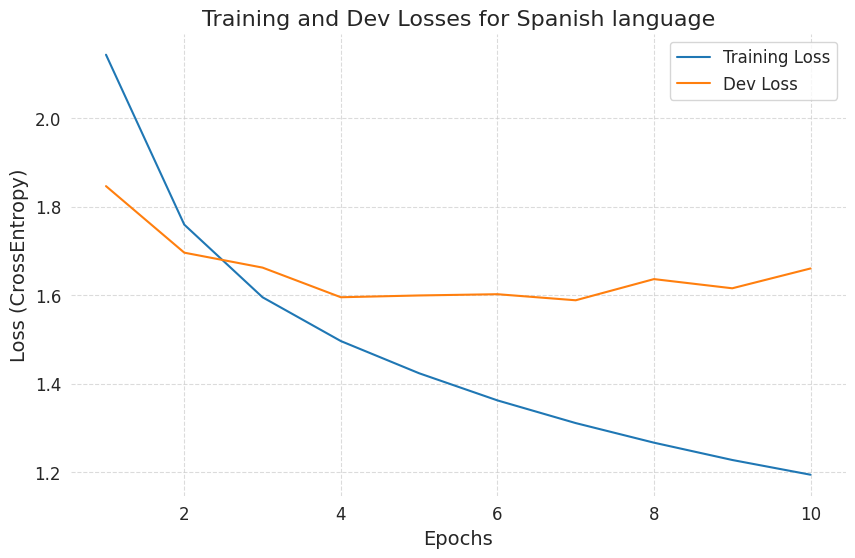

In [16]:
visualise_losses(sp_train_losses, sp_dev_losses, "Spanish")

In [17]:
# Example usage:
perplexity = calculate_perplexity(spanish_model, spanish_validation_dataset)
accuracy = calculate_character_accuracy(spanish_model, spanish_validation_dataset)

print(f"Perplexity on validation set: {perplexity}")
print(f"Character Accuracy on validation set: {accuracy}")

expected_names = spanish_names_tokenizer.words[:15]
generated_names = []

for exp_name in expected_names:
  generated_names.append(spanish_model.generate_names_starting_with(exp_name[:2], tokenizer=spanish_names_tokenizer, num_names=1, max_len=len(exp_name))[-1])

# Compare the generated names with the expected names (example comparison)
print("\nComparison:")
for i in range(10):
    print(f"Generated: {generated_names[i]}, Original word (example): {expected_names[i]}")


Perplexity on validation set: 5.577010154724121
Character Accuracy on validation set: 0.5048642075395217

Comparison:
Generated: veronic, Original word (example): verania
Generated: eduard carmel, Original word (example): edwin alfredo
Generated: edgar humberto , Original word (example): edgar francisco
Generated: blalia andr, Original word (example): blanca ines
Generated: oura, Original word (example): ousama
Generated: teres, Original word (example): telma
Generated: miguel, Original word (example): mihaela lacramioara
Generated: roberto car, Original word (example): roque mario
Generated: charlota, Original word (example): changqing
Generated: edgar, Original word (example): edmundo jose


# We will consider the aspects like:
 - Similarity of generated names to expected names in both cases
 - Character-level accuracy for cross-language generation
 - Structural differences between the names generated and the correct names
 - Expected vs. unexpected results.  Why?  Linguistic similarity of Italian and Spanish
 - Potential improvements for cross-lingual transfer

In [18]:
print(f"""
Evaluations:
Spanish language on Italian model: {calculate_character_accuracy(spanish_model, italian_validation_dataset)}
Italian language on Spanish model: {calculate_character_accuracy(italian_model, spanish_validation_dataset)}

Perplexity on Italian model: {calculate_perplexity(italian_model, spanish_validation_dataset)},
Perplexity on Spanish model: {calculate_perplexity(spanish_model, italian_validation_dataset)}
""")



Evaluations:
Spanish language on Italian model: 0.3598173515981735
Italian language on Spanish model: 0.3589379813538711

Perplexity on Italian model: 16.28691291809082,
Perplexity on Spanish model: 13.459516525268555



# Export the models for the second notebook

In [19]:
import pickle

# Save the Italian model
with open('italian_model.pkl', 'wb') as f:
    pickle.dump(italian_model, f)

# Save the Spanish model
with open('spanish_model.pkl', 'wb') as f:
    pickle.dump(spanish_model, f)
